In [67]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchsummary import summary
import matplotlib.pyplot as plt
import random
import numpy as np

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

No GPU available!


# Initial Steps

- Download the dataset 
- Split the Data - get the train validation and test - indices and data and labels
- Create Standardization function
- Apply Standardizarion
- Create tensorDatasets - TensorDataset to be able to operate on the dataset without having to load it all in memory

- Making the ML Functions :
    - Training Function 
    - Validation Function
    - Evaluate Function
    
- Set the Hyper Parameters
        - Seed
        - learning rate
        - Optimize
        - momentum
        - Number of Epochs
        - Batchsize
        - Test Batch Size 
        - Shuffle the training set every epoch: Yes/No?
        
- Instantiate the model, optimizer and losses

- Perform the Training 

In [56]:
# Downlaod the MNIST Data set
mnist_train = MNIST("./", download= True, train = True)
mnist_test = MNIST("./", download=True, train = True)

In [57]:
# Split the Data 
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1,random_state=42).split(mnist_train.train_data, mnist_train.train_labels)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

C:\Users\Niranjana\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\Niranjana\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [58]:
# Standardization function

def apply_standardization(X):
    X/=255
    X -= 0.1307
    X/= 0.3081
    return X


In [59]:
# Standardize the data
X_train, y_train = apply_standardization(mnist_train.train_data[indices[0]].float()), mnist_train.train_labels[indices[0]]
X_val, y_val = apply_standardization(mnist_train.train_data[indices[1]].float()),mnist_train.train_labels[indices[1]]

X_test,y_test = apply_standardization(mnist_test.test_data.float()),mnist_test.test_labels


C:\Users\Niranjana\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\Niranjana\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\Niranjana\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\Niranjana\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [60]:
# Create TorchTensor Datasets containing mnist_train, mnist_test, mnist_validate

mnist_train = TensorDataset(X_train, y_train.long())
mnist_validate = TensorDataset(X_val, y_val.long())
mnist_test = TensorDataset(X_test, y_test.long())


tensor(0.0001) tensor(1.0003)


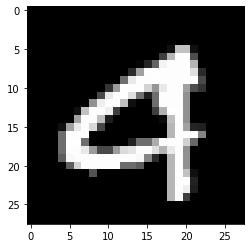

In [61]:
# Visualize the dataset
plt.imshow(X_train[50000], cmap = "gray")
print(X_train.mean(), X_train.std())

In [69]:
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2) # define a 2D convolutional layer
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)               # define a maxpool layer
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)           # new 2D convolutional layer
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)               # another maxpool layer
    self.c5 = nn.Linear(16*5*5, 120)                              # first linear layer
    self.f6 = nn.Linear(120, 84)                                  # second linear layer
    self.output = nn.Linear(84, 10)                               # final output layer
    self.act = nn.ReLU()                                          # activation function
    
  def forward(self, x):
    x = self.act(self.c1(x))                                      # activate pass through the first layer
    x = self.act(self.s2(x))                                      # activate pass through the second layer
    x = self.act(self.c3(x))                                      # activate pass through the third layer
    x = self.act(self.s4(x))                                      # activate pass through the fourth layer
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))                 # flatten (return a "flattened" view of the 3d tensor as inputs for the fully connected layer)
    x = self.act(self.c5(x))                                      # activate pass through fifth layer
    x = self.act(self.f6(x))                                      # activate pass through last layer
    return self.output(x)                                         # return output
  
x = torch.randn((1, 1, 28, 28))
model = LeNet5()
y = model(x)
print(y)
print(model)

tensor([[ 0.0308,  0.0938, -0.1437,  0.0305,  0.0357, -0.0449, -0.0016, -0.1339,
          0.0230, -0.0844]], grad_fn=<AddmmBackward0>)
LeNet5(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (s2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c5): Linear(in_features=400, out_features=120, bias=True)
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=10, bias=True)
  (act): ReLU()
)


# Training Function

In [71]:
def train(model, optimizer, criterion, data_loader):
    # Set it to train mode
    model.train()
    
    # Initialize the training loss and training accuracy
    train_loss, train_accuracy = 0, 0
    
    # Load the X and Y variables using the dataloader
    for X, y in data_loader:
        # ------------------------------------------------
        # Send the variables to the GPU
        X,y = X.to(device), y.to(device)
        
        # Set the gradient to zero 
        optimizer.zero_grad()
        
        # ------------------------------------------------
        # Convolutional forward function
        a2 = model(X.view(-1,1,28,28))
        
        # Loss criterion
        loss = criterion(a2, y)
        
        # Calculate the Backward gradient
        loss.backward()
        
        # ------------------------------------------------
        # Loss, Probability, Accuracy
        #-------------------------------------------------
        # Find the training loss
        train_loss + loss*X.size(0)
        
        # Find the output of the of the softmax function
        y_pred = F.log_softmax(a2, dim= 1).max(1)[1]
        
        # Train Accuracy
        train_accuracy += accuracy_score(y.cpu().numpy(),y_pred.detach().cpu().numpy())*x.size(0)
        # Update the Values
        optimizer.step()
    
    # return the train loss and train accracy
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
        

# Validation Function

In [72]:
def validate(model, criterion, data_loader):
    
    # Run the model in evaluate mode
    model.eval()
    
    # Initialize the validation loss and accuracy
    validation_loss, validation_accuracy = 0., 0.
    
    # extract the data from the dataloader
    for X, y in data_loader:
        
        # do not calculate the gradients
        with torch.no_grad():
            
            # Send the variables to the GPU
            X, y = X.to(device), y.to(device)
            
            # Convoltuional Forward Pass 
            a2 = model(X.view(-1, 1, 28, 28))
            
            # Set the loss criterion
            loss = criterion(a2, y)
            
            # Calculate the validation loss
            validation_loss += loss*X.size(0)
            
            # Find the probabilities usng softmax function
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
    
    # return the non- noramalized version of the losses        
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)
 

# Evaluate Function

In [73]:
def evaluate(model, data_loader):
    # Load the model in the training mode
    model.eval()
    
    # Array to save the original and evaluated/predicted ys
    ys, y_preds = [], []
    
    for X, y in data_loader:
        # Dont calculate the gradients for evaluate mode
        with torch.no_grad():
            # Load variables into the gpu
            X, y = X.to(device), y.to(device)
            
            # calculate a forward pass
            a2 = model(X.view(-1,1,28,28))
            
            # Find the probabilities using a softmax function
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            
            # Append the y_pred and the original y's
            ys.append(y.cpu().numpy())
            y_preds.apprend(y_pred.cpu(). numpy())
            
            
    return  np.concatenate(y_preds, 0), np.concatenate(ys,0)
            
            
    

# Set the HyperParameters

- Seed: 42
- learning rate: 1e-2
- Optimizer: SGD
- momentum: 0.9
- Number of Epochs: 30
- Batchsize: 64
- Test Batch Size (no effect on training apart from time): 1000
- Shuffle the training set every epoch: Yes

In [74]:

# Seed, learning rate , momentum , batch size, test batch size, epochs 
seed = 42
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 1000
n_epochs = 30

# Instantiate the model, optimizer and loss function

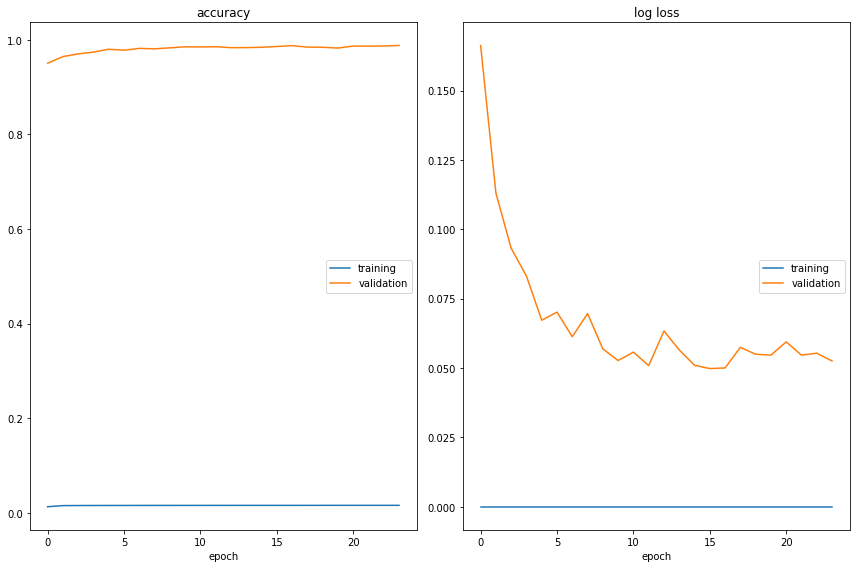

accuracy
	training         	 (min:    0.013, max:    0.016, cur:    0.016)
	validation       	 (min:    0.951, max:    0.988, cur:    0.988)
log loss
	training         	 (min:    0.000, max:    0.000, cur:    0.000)
	validation       	 (min:    0.050, max:    0.166, cur:    0.053)


In [ ]:
# Function to train the model with momentum as the hyperparameter
def train_model(momentum):
    
    
    # Set the seed
    set_seed(seed)
    # -------------------------------------------------
    # MODEL, OPTIMIZER, LOSS
    # ----------------------------------------------------
    # Instantiate the model
    model = LeNet5().to(device)
    
    # Select the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    
    # Select the loss function
    criterion = nn.CrossEntropyLoss()
    
    # ----------------------------------------------------
    # Create a train_loader 
    train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)
    
    # Create a validation loader
    validation_loader = DataLoader(mnist_validate, batch_size=test_batch_size, shuffle=False, num_workers=0)

    # Create a test loader
    test_loader = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False, num_workers=0)
    
    # --------------------------------------------------------------------
    # Instantiate liveloss with plotloss
    liveloss = PlotLosses()
    
    # Train for 30 epochs 
    for epoch in range(30):
        # Save the logs in a dict
        logs = {}
        
        # ------------------------------------
        # Call the training function on the defined model. loss and opimiaer functions
        train_loss , train_accuracy = train(model, optimizer, criterion, train_loader)
        
        # Add training log loss and accuracy to the logs
        logs['' + 'log loss'] = train_loss
        logs['' + 'accuracy'] = train_accuracy
        # ----------------------------------------------------
        #  Call the validation function
        validation_loss , validation_accuracy = validate(model, criterion, validation_loader)
        # Add validation log loss and accuracy to the logs
        logs['val_' + 'log loss'] = validation_loss
        logs['val_' + 'accuracy'] = validation_accuracy
        
        
        # Update the liveloss with the logs
        liveloss.update(logs)
      
        # Draw the live loss plot
        liveloss.draw()
    return model


# call the trianing model
model = train_model(0.5)
    